In [2]:
import matplotlib.pyplot as plt
import numpy as np

### Probabilty distribution and Histogram

In [3]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [4]:
belief = np.array([1/3, 1/3, 0, 0, 0, 0, 0, 0, 1/3, 0])
x = np.array([i for i in range(10)])

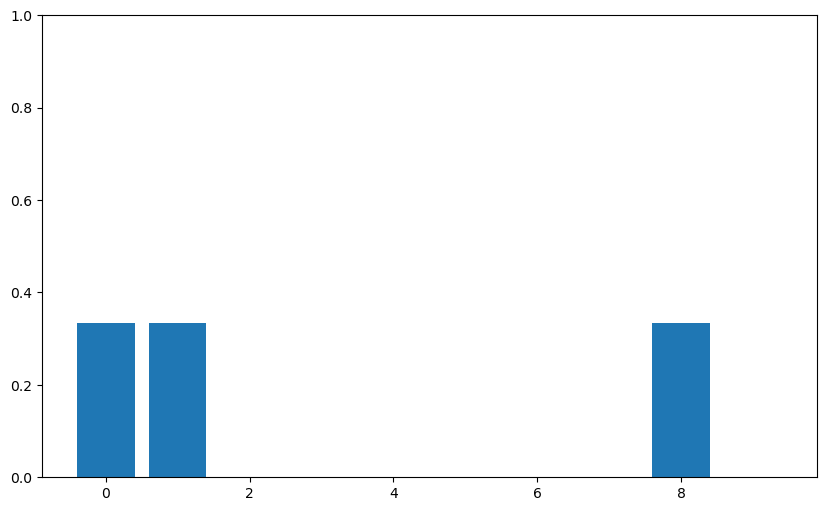

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x, belief)
ax.set_ylim(0, 1.0)
plt.show()

In [6]:
def plot_prob_distri(x, y, title, color='#ff8015'):
    plt.figure(figsize=(10, 6))
    plt.rc('axes', axisbelow=True)
    plt.grid()
    plt.bar(x, y, color=color)
    plt.ylim(0, 1.0)
    plt.title(title)
    plt.show()

### Noisy sensor

In [7]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale

In [8]:
belief = np.array([0.1] * 10)
reading = 1
update_belief(hallway, belief, reading, correct_scale=3.)

Belief:  [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
Sum =  1.6000000000000003


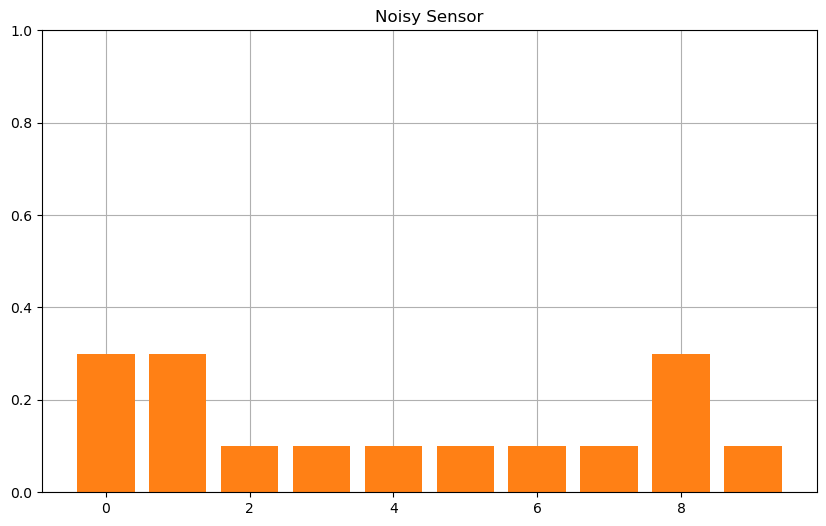

In [9]:
print("Belief: ", belief)
print("Sum = ", sum(belief))
plot_prob_distri([i for i in range(10)], belief, title="Noisy Sensor")

Normalized into a probability distribution, the sum of belief now equal to 1

In [10]:
belief /= sum(belief) 

### Improved update version

In this case , $ Scale = \frac{prob_{correct}}{prob_{incorrect}}= \frac{prob_{correct}}{1-prob_{incorrect}}$, and $ prob_{correct} $ represent the probabilty of the sensor measurement is right

In [11]:
from filterpy.discrete_bayes import normalize

In [12]:
def scaled_update(hall, belief, z, z_prob):
    scale = z_prob / (1. - z_prob)
    belief[hall==z] *= scale
    normalize(belief)

belief = np.array([0.1] * 10)
scaled_update(hallway, belief, z=1, z_prob=.75)

1.0


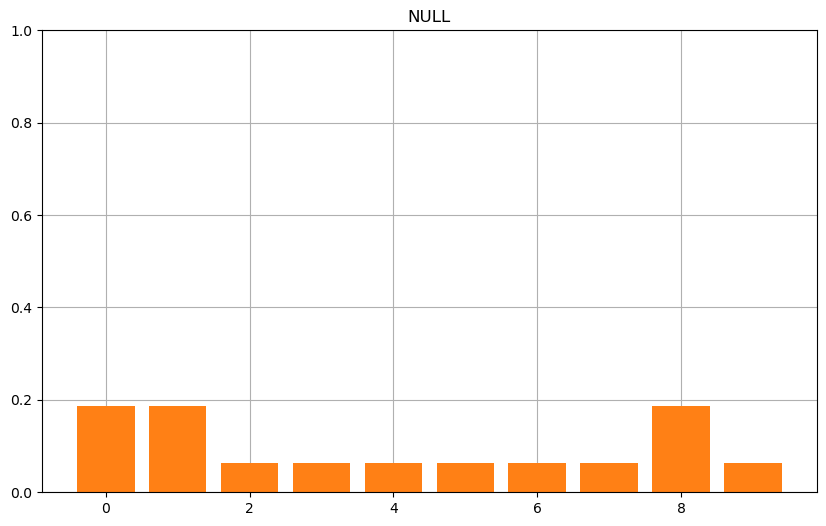

In [13]:
print(sum(belief))
plot_prob_distri([i for i in range(10)], belief, title="NULL")

### Cast the scaled_update function into likelihood format

In [14]:
def scaled_update(hall, belief, z, z_prob):
    scale = z_prob / (1. - z_prob)
    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return normalize(likelihood*belief)

### General Version, compute likelihood matrix on your own

In [15]:
from filterpy.discrete_bayes import update

In [16]:
def lh_hallway(hall, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""

    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

In [17]:
belief = np.array([0.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
update(likelihood, belief)  

array([0.1875, 0.1875, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.1875, 0.0625])

### Incorporating Movement

In [18]:
def perfect_predict(belief, move):
    """ move the position by `move` spaces, where positive is 
    to the right, and negative is to the left
    """

    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move) % n]
    return result

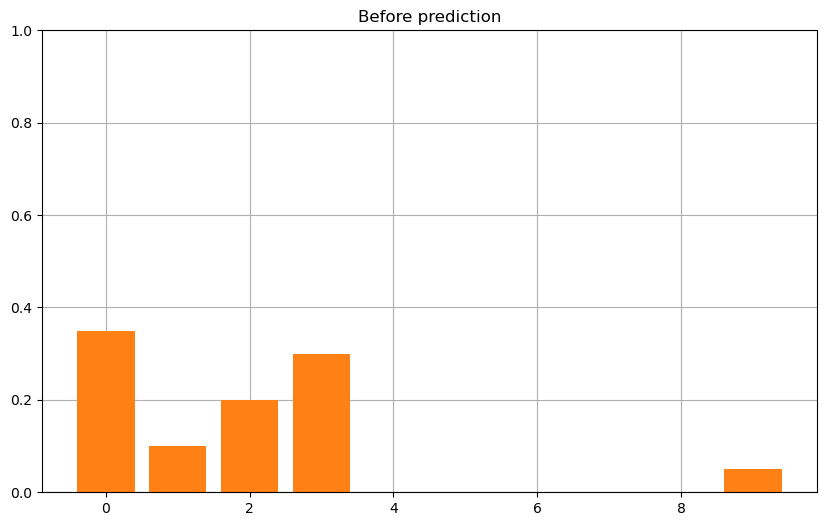

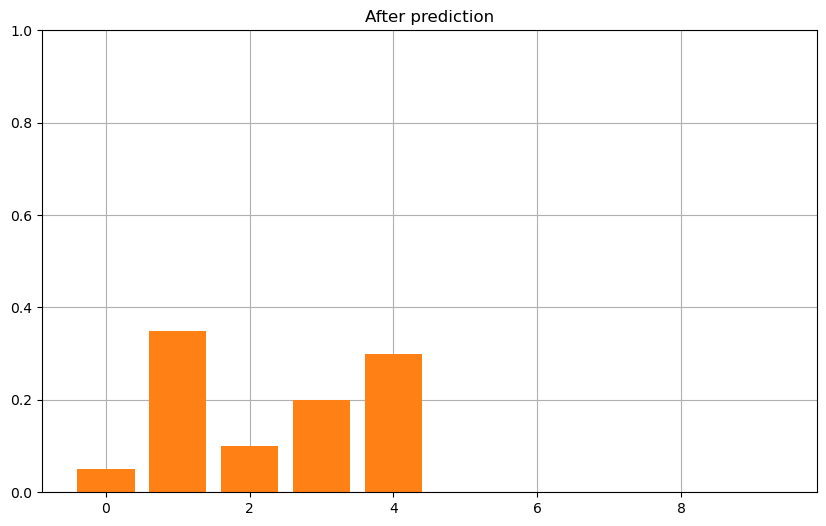

In [19]:
belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
plot_prob_distri([i for i in range(10)], belief, title='Before prediction')

belief = perfect_predict(belief, 1)
plot_prob_distri([i for i in range(10)], belief, title='After prediction')

### Interactive Simulation of Movement

In [20]:
from ipywidgets import interact, IntSlider

In [21]:
belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
perfect_beliefs = []

for _ in range(20):
    # Simon takes one step to the right
    belief = perfect_predict(belief, 1)
    perfect_beliefs.append(belief)

def simulate(time_step):
    plot_prob_distri([i for i in range(10)], perfect_beliefs[time_step], title='Simulation')
    
interact(simulate, time_step=IntSlider(value=0, max=len(perfect_beliefs)-1));

interactive(children=(IntSlider(value=0, description='time_step', max=19), Output()), _dom_classes=('widget-in…

### Incorporate uncertainty into prio prediction, or to say noisy movement measurement in process model 

In [22]:
def predict_movement(belief, move, p_under, p_correct, p_over):

    n = len(belief)
    prior_result = np.zeros(n)
    for i in range(n):
        prior_result[i] = (
            # it's like a convolution process: 
            #       kernel = [p_under, p_correct, p_over]
            #       target = belief[i-move-1, i-move+1]                    
            belief[(i-move) % n] * p_correct + 
            belief[(i-move-1) % n] * p_over + 
            belief[(i-move+1) % n] * p_under)
    return prior_result 

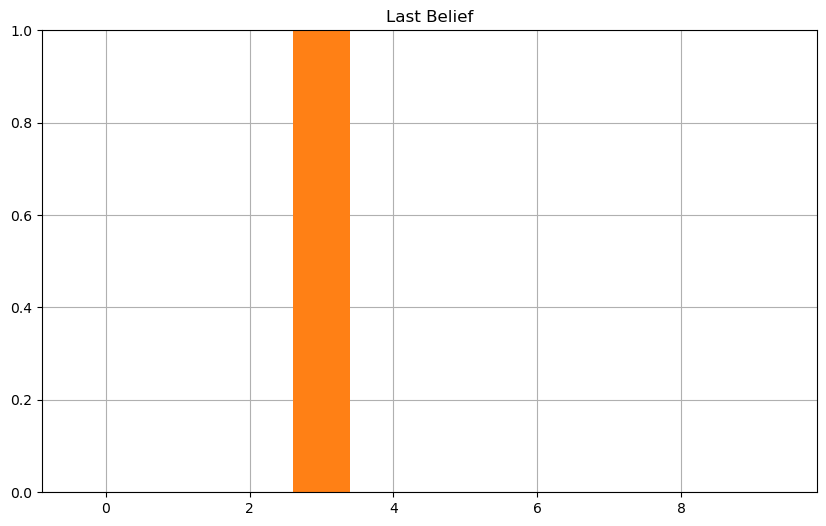

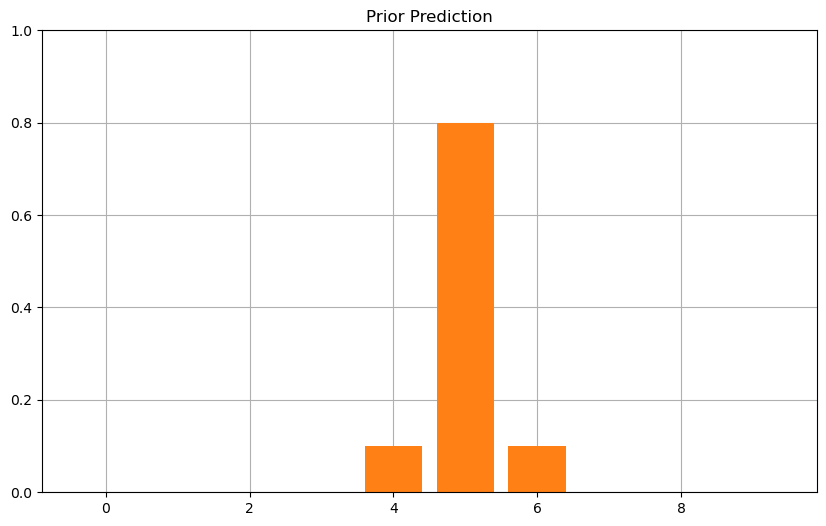

In [23]:
belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
prior_predict = predict_movement(belief, 2, .1, .8, .1)
plot_prob_distri([i for i in range(10)], belief, title='Last Belief')
plot_prob_distri([i for i in range(10)], prior_predict, title='Prior Prediction')

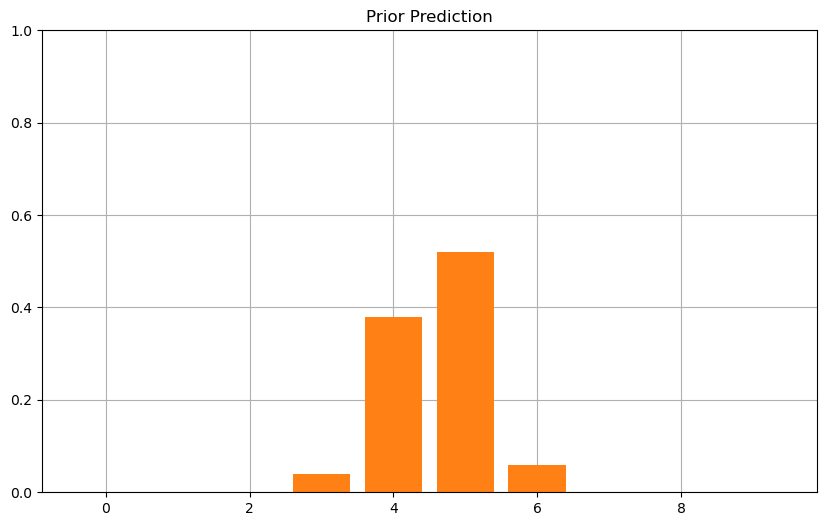

array([0.  , 0.  , 0.  , 0.04, 0.38, 0.52, 0.06, 0.  , 0.  , 0.  ])

In [24]:
belief = [0, 0, .4, .6, 0, 0, 0, 0, 0, 0]
prior_predict = predict_movement(belief, 2, .1, .8, .1)
plot_prob_distri([i for i in range(10)], prior_predict, title='Prior Prediction')
prior_predict

> If you look at the probabilities after performing the update you might be dismayed. In the example above we started with probabilities of 0.4 and 0.6 in two positions; after performing the update the probabilities are not only lowered, but they are strewn out across the map. If the sensor is noisy we lose some information on every prediction. Suppose we were to perform the prediction an infinite number of times - what would the result be? If we lose information on every step, we must eventually end up with no information at all, and our probabilities will be equally distributed across the belief array.

In [25]:
belief = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predict_beliefs = []
    
for i in range(100):
    belief = predict_movement(belief, 1, .1, .8, .1)
    predict_beliefs.append(belief)

print('Final Belief:', belief)

# make interactive plot
def show_prior(step):
    plot_prob_distri([i for i in range(10)], predict_beliefs[step-1], title='Prior Prediction')   

interact(show_prior, step=IntSlider(value=1, max=len(predict_beliefs)));

Final Belief: [0.10407069 0.10329322 0.10125784 0.09874205 0.09670682 0.09592945
 0.09670682 0.09874205 0.10125784 0.10329322]


interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

This must be what accumulation error would look like !

### Generalizing with Convolution - with different move offset and kernel size (movement measure noise)

(Prior) State Propogation Model: 

Single Value (Simplely add movement on it): $ \bar{x}_{k+1} = x_k + f_{x}(\bullet) $

Probability (Convolution): $ \bar{\mathbf{x}}_{k+1} = \mathbf{x}_k * f_{\mathbf{x}}(\bullet) $ 

In [26]:
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN-1)/2)

    prior = np.zeros(N)
    for i in range(N):
        for k in range(kN):
            index = (i-offset+(width-k)) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

In [27]:
from filterpy.discrete_bayes import predict

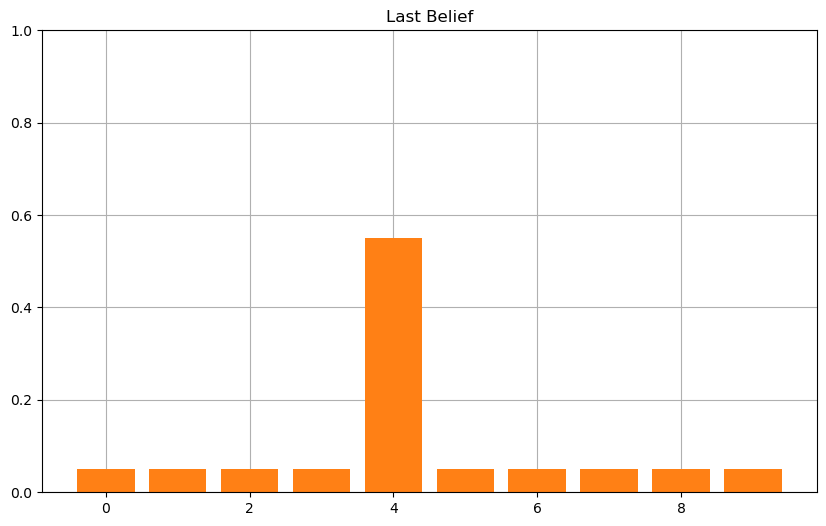

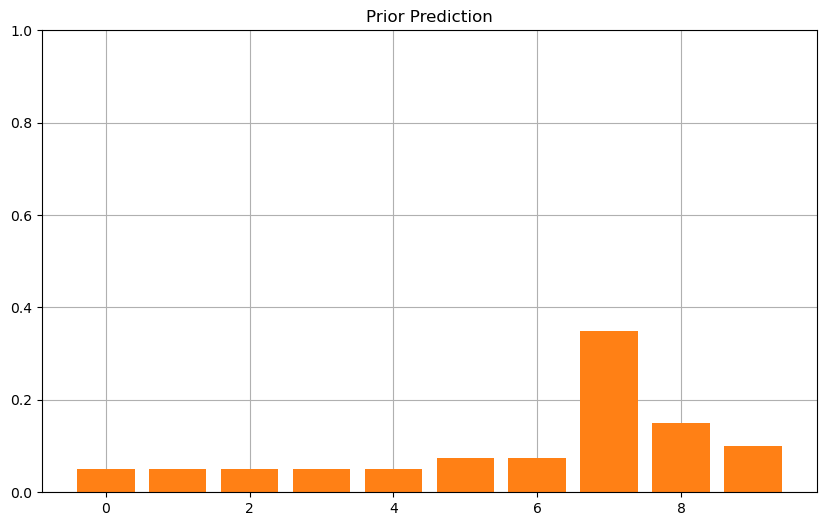

In [28]:
belief = [.05, .05, .05, .05, .55, .05, .05, .05, .05, .05]
prior = predict(belief, offset=3, kernel=[.05, .05, .6, .2, .1])
plot_prob_distri([i for i in range(10)], belief, title='Last Belief')
plot_prob_distri([i for i in range(10)], prior, title='Prior Prediction')

### Integrating Measurements and Movement Updates

### The Discrete Bayes Algorithm

In [31]:
from kf_book import book_plots

In [34]:
def discrete_bayes_sim(kernel, measurements, z_prob, hallway):
    posterior = np.array([.1]*10)
    priors, posteriors = [], []
    for i, z in enumerate(measurements):
        prior = predict(posterior, 1, kernel)
        priors.append(prior)

        likelihood = lh_hallway(hallway, z, z_prob)
        posterior = update(likelihood, prior)
        posteriors.append(posterior)
    return priors, posteriors


def plot_posterior(hallway, posteriors, i):
    plt.title('Posterior')
    book_plots.bar_plot(hallway, c='k')
    book_plots.bar_plot(posteriors[i], ylim=(0, 1.0))
    plt.axvline(i % len(hallway), lw=5)
    plt.show()
    
def plot_prior(hallway, priors, i):
    plt.title('Prior')
    book_plots.bar_plot(hallway, c='k')
    book_plots.bar_plot(priors[i], ylim=(0, 1.0), c='#ff8015')
    plt.axvline(i % len(hallway), lw=5)
    plt.show()

def animate_discrete_bayes(hallway, priors, posteriors):
    def animate(step):
        step -= 1
        i = step // 2    
        if step % 2 == 0:
            plot_prior(hallway, priors, i)
        else:
            plot_posterior(hallway, posteriors, i)
    
    return animate

In [35]:
# change these numbers to alter the simulation
kernel = (.1, .8, .1)
z_prob = 1.0
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

# measurements with no noise
zs = [hallway[i % len(hallway)] for i in range(50)]

priors, posteriors = discrete_bayes_sim(kernel, zs, z_prob, hallway)
interact(animate_discrete_bayes(hallway, priors, posteriors), step=IntSlider(value=1, max=len(zs)*2));

interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

>"Another thing to note is how accurate our estimate becomes when we are in front of a door, and how it degrades when in the middle of the hallway. This should make intuitive sense. There are only a few doorways, so when the sensor tells us we are in front of a door this boosts our certainty in our position. A long stretch of no doors reduces our certainty."

Less feature running environment !

### Bad Measurement

In [37]:
hallway = np.array([1, 0, 1, 0, 0]*2)
kernel = (.1, .8, .1)
prior = np.array([.1] * 10)
zs = [1, 0, 1, 0, 0, 1]
z_prob = 0.75
priors, posteriors = discrete_bayes_sim(kernel, zs, z_prob, hallway)
interact(animate_discrete_bayes(hallway, priors, posteriors), step=IntSlider(value=12, max=len(zs)*2));

interactive(children=(IntSlider(value=12, description='step', max=12), Output()), _dom_classes=('widget-intera…

bad measurement between step 6 and step 7:

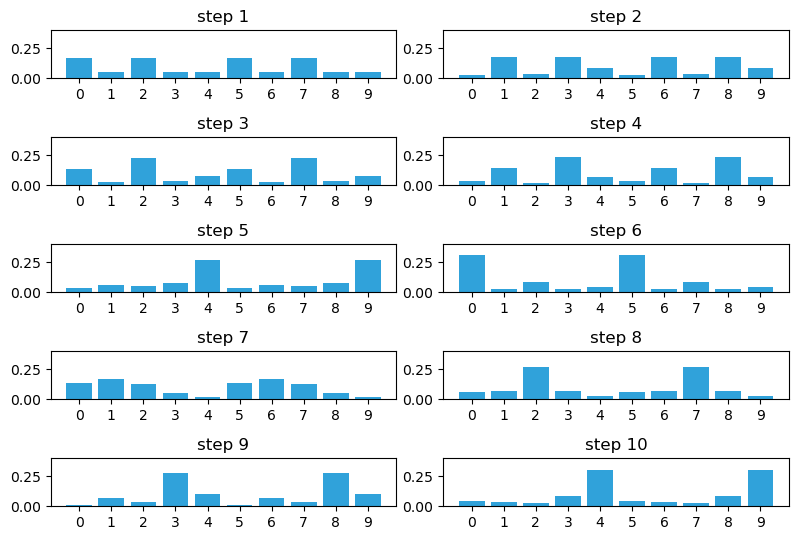

In [39]:
with book_plots.figsize(y=5.5):
    measurements = [1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
    for i, m in enumerate(measurements):
        likelihood = lh_hallway(hallway, z=m, z_prob=.75)
        posterior = update(likelihood, prior)
        prior = predict(posterior, 1, kernel)
        plt.subplot(5, 2, i+1)
        book_plots.bar_plot(posterior, ylim=(0, .4), title=f'step {i+1}')
    plt.tight_layout()

### Simulate the train behavior

In [52]:
class Train(object):

    def __init__(self, track_len, kernel=[1.], sensor_accuracy=.9) -> None:
        self.track_len = track_len
        self.pos = 0
        self.kernel = kernel
        self.sensor_accuracy = sensor_accuracy
    
    def move(self, distance=1):
        """ move in the specified direction
        with some small chance of error"""

        self.pos += distance

        # Introduce some random error in movement
        r = np.random.random()
        s = 0
        offset = -(len(self.kernel)-1) / 2
        for k in self.kernel:
            s += k
            if r <= s:
                break
            offset += 1
        self.pos = int((self.pos + offset) % self.track_len)
        return self.pos
    
    def sense(self):
        pos = self.pos
         # insert random sensor error
        if np.random.random() > self.sensor_accuracy:
            if np.random.random() > 0.5:
                pos += 1
            else:
                pos -= 1
        return pos

In [46]:
def train_filter(iterations, kernel, sensor_accuracy, 
             move_distance, do_print=True):
    track = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    prior = np.array([.9] + [0.01]*9)
    posterior = prior[:]
    normalize(prior)
    
    robot = Train(len(track), kernel, sensor_accuracy)
    for i in range(iterations):
        # move the robot and
        robot.move(distance=move_distance)

        # peform prediction
        prior = predict(posterior, move_distance, kernel)       

        #  and update the filter
        m = robot.sense()
        likelihood = lh_hallway(track, m, sensor_accuracy)
        posterior = update(likelihood, prior)
        index = np.argmax(posterior)

        if do_print:
            print(f'time {i}: pos {robot.pos}, sensed {m}, at position {track[robot.pos]}')
            conf = posterior[index] * 100
            print(f'        estimated position is {index} with confidence {conf:.4f}%:')            

    book_plots.bar_plot(posterior)
    if do_print:
        print()
        print('final position is', robot.pos)
        index = np.argmax(posterior)
        conf = posterior[index]*100
        print(f'Estimated position is {index} with confidence {conf:.4f}')

time 0: pos 4, sensed 4, at position 4
        estimated position is 4 with confidence 99.9900%:
time 1: pos 8, sensed 8, at position 8
        estimated position is 8 with confidence 100.0000%:
time 2: pos 2, sensed 2, at position 2
        estimated position is 2 with confidence 100.0000%:
time 3: pos 6, sensed 6, at position 6
        estimated position is 6 with confidence 100.0000%:

final position is 6
Estimated position is 6 with confidence 100.0000


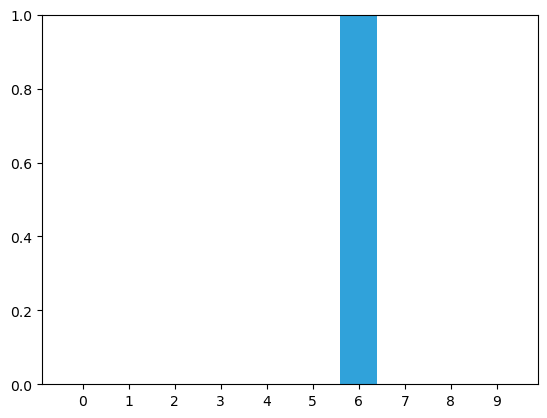

In [53]:
import random

random.seed(3)
np.set_printoptions(precision=2, suppress=True, linewidth=60)
train_filter(4, kernel=[1.], sensor_accuracy=.999,
             move_distance=4, do_print=True)

Add some error in movements and measurements

time 0: pos 4, sensed 4, at position 4
        estimated position is 4 with confidence 96.0390%:
time 1: pos 8, sensed 8, at position 8
        estimated position is 8 with confidence 96.8094%:
time 2: pos 2, sensed 2, at position 2
        estimated position is 2 with confidence 96.9180%:
time 3: pos 6, sensed 6, at position 6
        estimated position is 6 with confidence 96.9331%:

final position is 6
Estimated position is 6 with confidence 96.9331


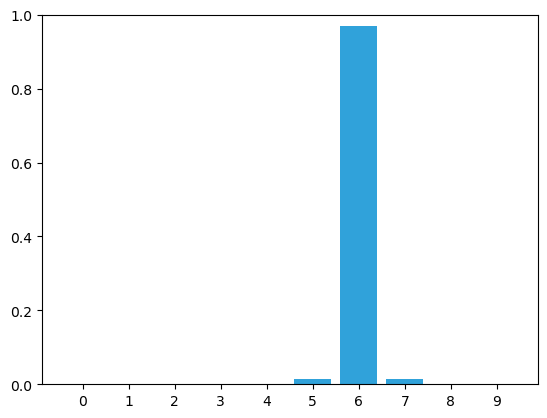

In [65]:
random.seed(5)
train_filter(4, kernel=[.1, .8, .1], sensor_accuracy=.9,
         move_distance=4, do_print=True)